In [1354]:
import numpy as np
import pandas as pd
import random
import pickle

import catboost as catb

from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1218]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [1219]:
import warnings
warnings.filterwarnings('ignore')

In [1220]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1221]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [1222]:
def imputer_rfr(data, target_col, params):
    y_train = None
    pred_train = None
    
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
#    model = RandomForestRegressor()
#    model = LinearRegression()
    model = GradientBoostingRegressor(**params)
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
#    print(f"r2 {target_col} на train: {r2_score(y_train, pred_train)}")
#    print(f"r2 {target_col} на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

#    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, pred

In [1223]:
matplotlib.rcParams.update({'font.size': 14})

In [1224]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [1225]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(20)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7480,Home Mortgage,1157974.0,1 year,0.0,11.0,27.9,1345652.0,0.0,40.0,0.0,debt consolidation,Short Term,432520.0,176643.0,8183.0,747.0,0
7481,Home Mortgage,2127202.0,10+ years,0.0,7.0,21.5,369116.0,0.0,27.0,0.0,debt consolidation,Short Term,559790.0,303164.0,16380.0,739.0,0
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7483,Rent,567435.0,8 years,0.0,11.0,17.1,365750.0,0.0,8.0,0.0,debt consolidation,Long Term,328526.0,181944.0,6431.0,658.0,1
7484,Home Mortgage,1258712.0,8 years,0.0,6.0,9.5,364210.0,0.0,NaN,0.0,debt consolidation,Short Term,161436.0,93100.0,4689.0,741.0,0
7485,Rent,2687664.0,< 1 year,0.0,14.0,16.7,429154.0,0.0,77.0,0.0,debt consolidation,Short Term,466796.0,278711.0,44122.0,736.0,1
7486,Rent,5327372.0,1 year,0.0,7.0,12.1,605638.0,0.0,NaN,0.0,debt consolidation,Short Term,111760.0,292904.0,8080.0,750.0,0
7487,Home Mortgage,1542952.0,10+ years,0.0,7.0,12.5,232364.0,0.0,59.0,0.0,debt consolidation,Long Term,267982.0,198873.0,15430.0,695.0,1
7488,Rent,465405.0,5 years,0.0,5.0,7.7,51744.0,0.0,33.0,0.0,home improvements,Short Term,129338.0,8721.0,13535.0,728.0,0
7489,Home Mortgage,1394942.0,10+ years,0.0,15.0,27.2,1441396.0,0.0,35.0,0.0,debt consolidation,Short Term,753764.0,496698.0,16972.0,742.0,1


In [1226]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [1227]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [1228]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


In [1229]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [1230]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = train_df.select_dtypes(include='float64').columns.tolist()
NUM_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [1231]:
CAT_FEATURE_NAMES =train_df.select_dtypes(include='object').columns.tolist()
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

## 1. EDA 

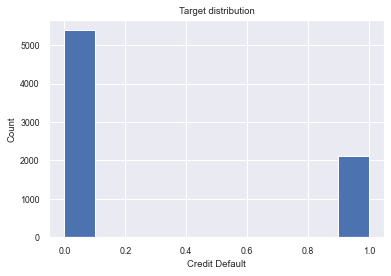

In [1232]:
#plt.figure(figsize = (16, 8))

train_df['Credit Default'].hist()
plt.ylabel('Count')
plt.xlabel('Credit Default')

plt.title('Target distribution')
plt.show()

In [1233]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [1234]:
train_df.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [1235]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [1236]:
test_df['Home Ownership'].value_counts()

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

In [1237]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [1238]:
test_df['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

In [1239]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [1240]:
test_df['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [1241]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [1242]:
test_df['Term'].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

In [1243]:
min_purpose = train_df['Purpose'].value_counts() < 20
min_purpose = min_purpose[min_purpose == True].index.tolist()
train_df['Purpose'].replace(min_purpose, 'other', inplace=True)
train_df['Purpose'].value_counts()

debt consolidation    5944
other                  711
home improvements      412
business loan          129
buy a car               96
medical bills           71
major purchase          40
take a trip             37
buy house               34
small business          26
Name: Purpose, dtype: int64

### Просмотр пропусков

In [1244]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

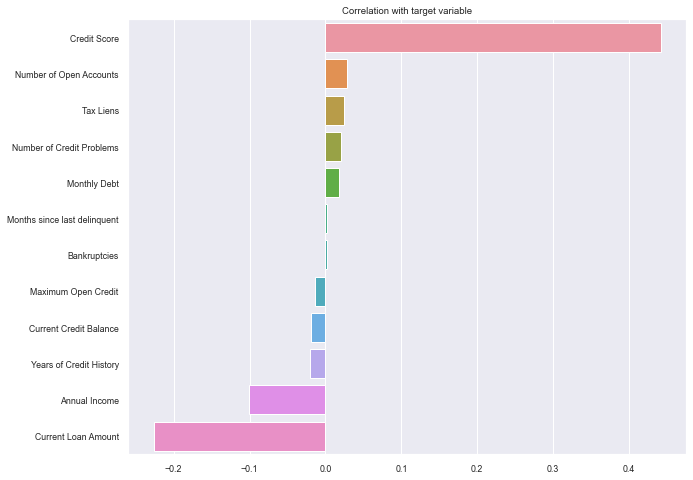

In [1245]:
corr_with_target = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

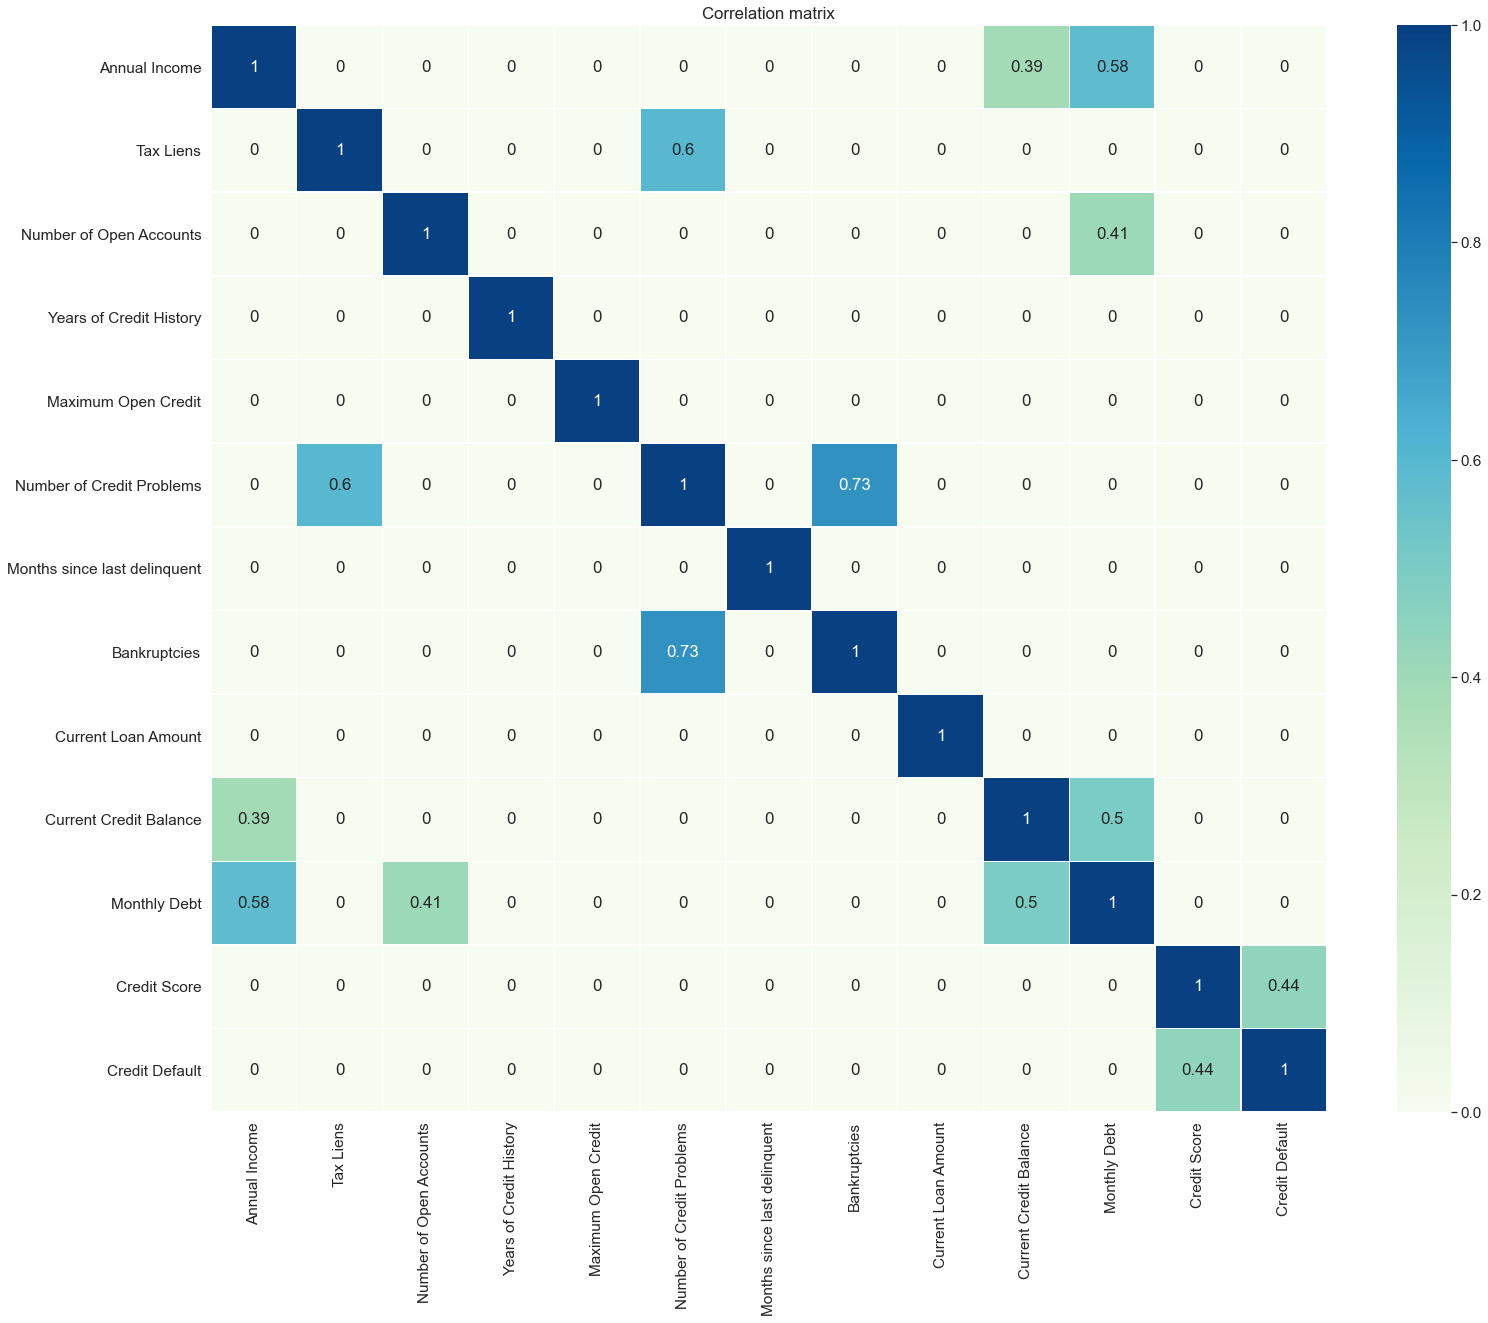

In [1246]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Проверим распределения вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


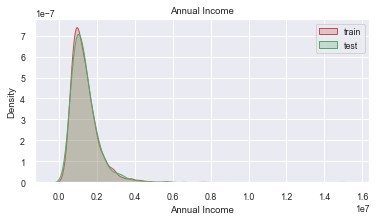

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


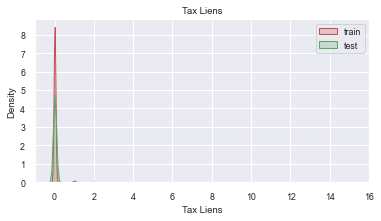

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


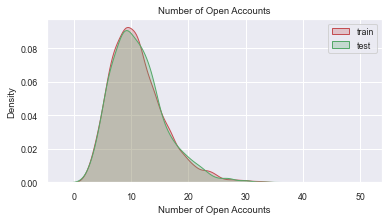

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


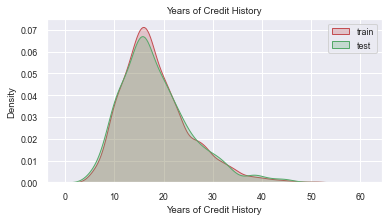

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


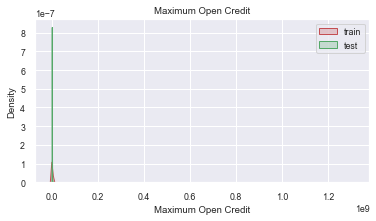

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


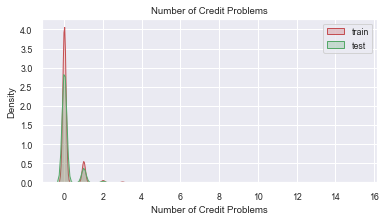

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


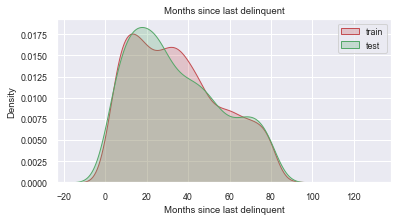

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


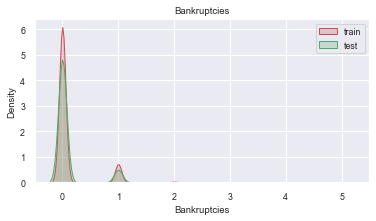

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


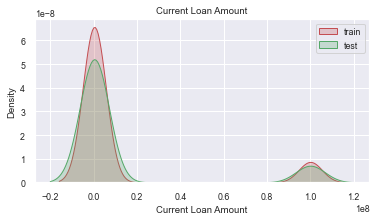

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


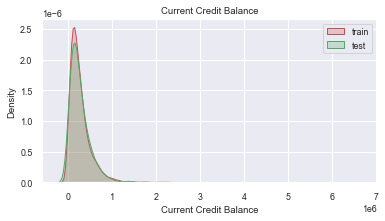

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


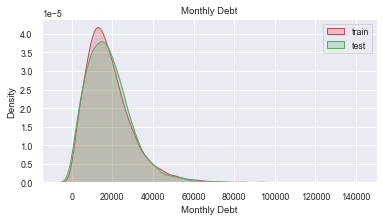

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


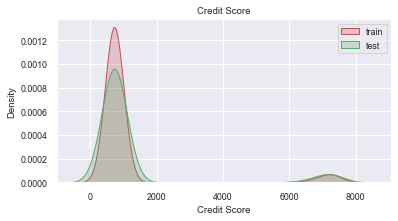

In [1247]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

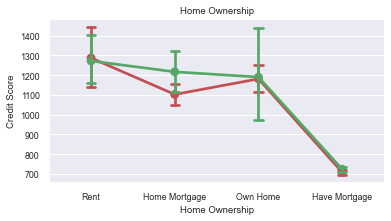

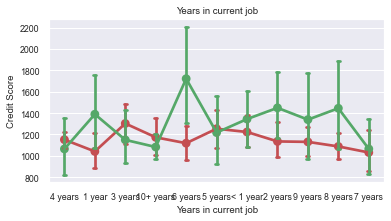

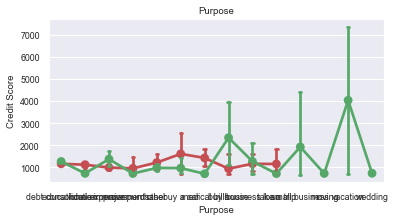

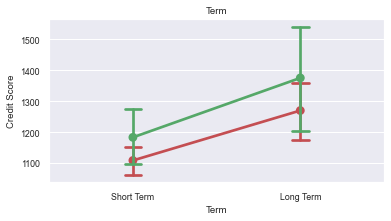

In [1248]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=train_df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test_df, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

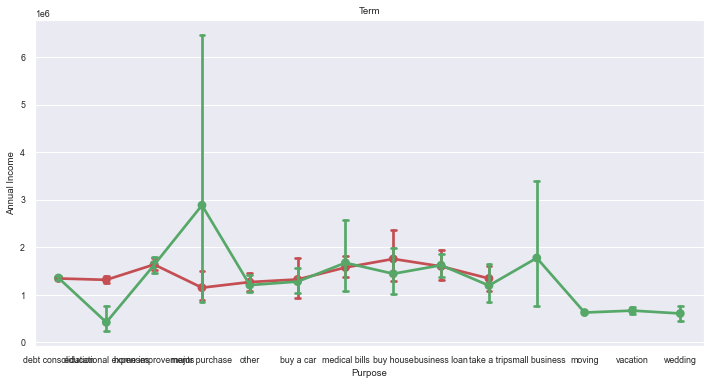

In [1249]:
figsize = (12, 6)
plt.figure(figsize=figsize)
sns.pointplot(x='Purpose', y='Annual Income', data=train_df, capsize=.1, label='train', color='r')
sns.pointplot(x='Purpose', y='Annual Income', data=test_df, capsize=.1, label='test', color='g')
plt.title(col) 
plt.show()

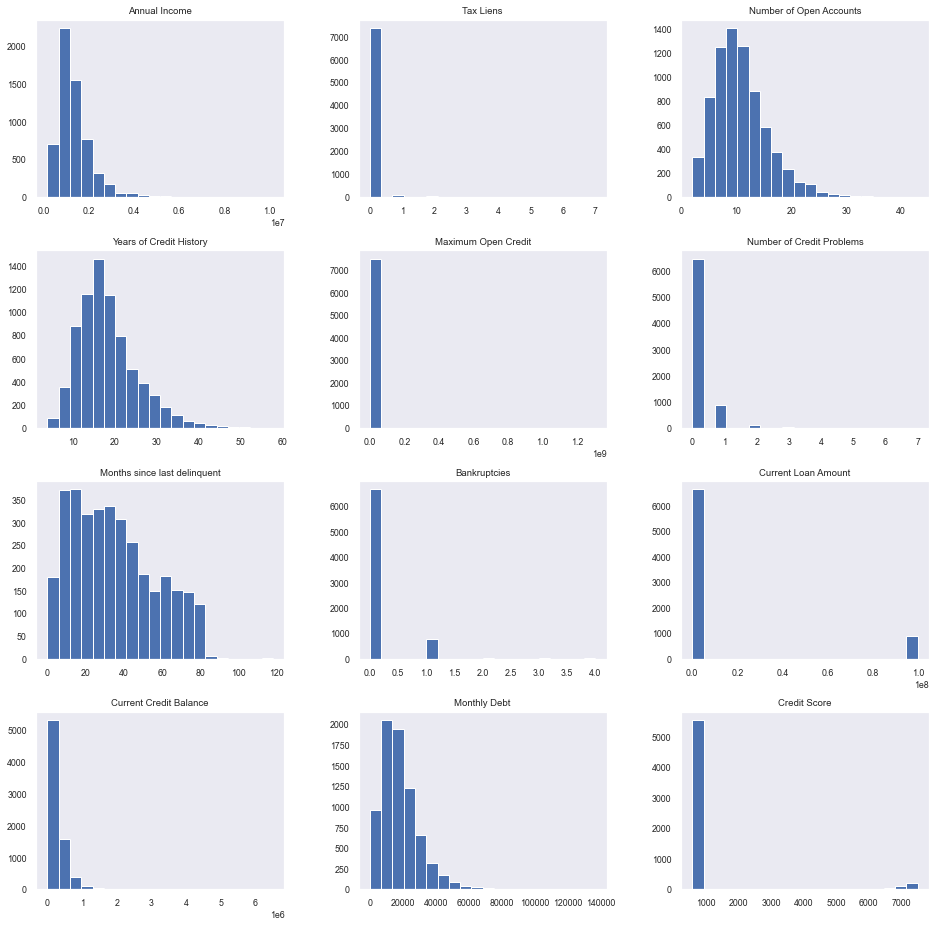

In [1250]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [1251]:
train_df.loc[train_df['Tax Liens'] > 1, 'Tax Liens']  = 1
train_df['Tax Liens'].value_counts()

0.0    7366
1.0     134
Name: Tax Liens, dtype: int64

In [1252]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [1253]:
train_df['Current Credit Balance'].value_counts()
train_df['Current Credit Balance'].median()

209323.0

In [1254]:
train_df['Annual Income'].isna().sum()

1557

In [1255]:
train_df.loc[train_df['Tax Liens'] > 1, 'Tax Liens']  = 1
train_df.loc[train_df['Number of Credit Problems'] > 3, 'Number of Credit Problems']  = 3
train_df.loc[train_df['Monthly Debt'] > 100000, 'Monthly Debt']  = 100000
train_df.loc[train_df['Bankruptcies'] > 1, 'Bankruptcies']  = 1        
train_df.loc[train_df['Maximum Open Credit'] > 1000000, 'Maximum Open Credit']  = 1000000
train_df.loc[train_df['Current Credit Balance'] > 1000000, 'Current Credit Balance']  = 1000000
train_df.loc[train_df['Current Loan Amount'] > 1000000, 'Current Loan Amount']  = 1000000
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = 1000

## Генерация признаков

In [1256]:
mean_all = train_df.groupby(['Credit Default', 'Term'], as_index=False).agg({'Annual Income': 'mean',
                                                                    'Current Loan Amount': 'mean',
                                                                    'Current Credit Balance': 'mean',
                                                                    'Monthly Debt': 'mean',
                                                                    'Credit Score': 'mean'})
mean_all

,Credit Default,Term,Annual Income,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,Long Term,1.586145e+06,509977.544326,332414.235816,21235.346631,701.989669
1,0,Short Term,1.370061e+06,388204.597793,259200.561634,17355.212961,729.740490
2,1,Long Term,1.367218e+06,438855.676471,318813.243873,21176.825980,764.833605
3,1,Short Term,1.133982e+06,256058.152660,241712.352352,17083.790285,795.009269


In [1257]:
df_cat = train_df.groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Term'
})
df_cat = pd.DataFrame(df_cat)

df_cat

,Term,target_encode_Term
0,Long Term,0.419753
1,Short Term,0.233441


In [1258]:
df_cat = train_df.groupby(['Home Ownership', 'Term'], as_index=False).mean()[['Term', 'Home Ownership',
                                                                              'Credit Default']].rename(columns={
    'Credit Default': 'target_encode_Term_Home'
})
df_cat = pd.DataFrame(df_cat)

df_cat

,Term,Home Ownership,target_encode_Term_Home
0,Long Term,Have Mortgage,1.000000
1,Short Term,Have Mortgage,0.090909
2,Long Term,Home Mortgage,0.385032
3,Short Term,Home Mortgage,0.193434
4,Long Term,Own Home,0.401163
5,Short Term,Own Home,0.258947
6,Long Term,Rent,0.481873
7,Short Term,Rent,0.269079


In [1259]:
train_df = train_df.merge(df_cat, on=['Home Ownership', 'Term'], how='left')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,target_encode_Term_Home
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,1000000.0,47386.0,7914.0,749.0,0,0.258947
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1000000.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0.401163
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1000000.0,0.0,NaN,0.0,debt consolidation,Short Term,1000000.0,308389.0,13651.0,742.0,0,0.193434
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0.258947
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0.269079


In [1260]:
train_df['Current Loan Amount'].median()

309573.0

In [1261]:
bins = [500, 600, 755, 1000]
train_df['Credit Score_cat'] = pd.cut(train_df['Credit Score'], bins=bins, labels=False)
train_df['Credit Score_cat'].fillna(-1, inplace=True)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,target_encode_Term_Home,Credit Score_cat
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,1000000.0,47386.0,7914.0,749.0,0,0.258947,1.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1000000.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0.401163,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1000000.0,0.0,NaN,0.0,debt consolidation,Short Term,1000000.0,308389.0,13651.0,742.0,0,0.193434,1.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0.258947,1.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0.269079,1.0


In [1262]:
df_cat = train_df.groupby('Credit Score_cat', as_index=False).mean()[['Credit Score_cat', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_Credit'})
df_cat = pd.DataFrame(df_cat)

df_cat

,Credit Score_cat,target_encode_Credit
0,-1.0,0.339756
1,0.0,0.571429
2,1.0,0.212697
3,2.0,1.000000


In [1263]:
train_df['Months_balance'] = train_df['Annual Income'] / 12 - train_df['Monthly Debt']
train_df['Months_balance'].describe()

count      5943.000000
mean      95595.925529
std       64260.538389
min       10294.916667
25%       56959.083333
50%       80344.083333
75%      115067.166667
max      784543.666667
Name: Months_balance, dtype: float64

In [1264]:
train_df['loan balance'] = train_df['Maximum Open Credit']  - train_df['Current Loan Amount']
train_df['loan balance'].describe()

count       7500.000000
mean      142630.046667
std       350148.486901
min     -1000000.000000
25%       -21961.500000
50%       140932.000000
75%       366201.000000
max       978484.000000
Name: loan balance, dtype: float64

In [1265]:
train_df['koef_credit'] = (train_df['Current Loan Amount']  + train_df['Current Credit Balance']) / train_df['Annual Income']

### Обобщение

In [1266]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
df_copy_1 = train_df.copy()

In [1267]:
class DataPreprocessing:    
    
    def __init__(self):
        self.medians = None
        self.model_annual_income = None
        self.model_months = None
        self.model_credit = None
        
    def fit(self, X):      
        # Расчет медиан
        self.medians = X.median()    
        
    def first_transform(self, X):
        
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace=True)
        
#        X.fillna(self.medians, inplace=True)

        X['Annual Income median'] = X['Annual Income']
        X['Annual Income median'].fillna(self.medians['Annual Income'], inplace=True)
        
        X['Months since last delinquent median'] = X['Months since last delinquent']
        X['Months since last delinquent median'].fillna(self.medians['Months since last delinquent'], inplace=True)
        
        X['Credit Score median'] = X['Credit Score']
        X['Credit Score median'].fillna(self.medians['Credit Score'], inplace=True)
        
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = '10+ years'
       
        min_purpose = X['Purpose'].value_counts() < 100
        min_purpose = min_purpose[min_purpose == True].index.tolist()
        X['Purpose'].replace(min_purpose, 'other', inplace=True)
        X['Purpose'].value_counts()

        X.replace({
            'Years in current job': {
                '10+ years': 10,
                '2 years': 2,
                '3 years': 3,
                '< 1 year': 0,
                '5 years': 5,
                '1 year': 1,
                '4 years': 4,
                '6 years': 6,
                '7 years': 7,
                '8 years': 8,
                '9 years': 9
            }
        })
        
#        X.drop('Years in current job', axis=1, inplace=True)
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
#        X.drop('Home Ownership', axis=1, inplace=True)
        X = pd.concat([X, pd.get_dummies(X['Term'])], axis=1)
#        X.drop('Term', axis=1, inplace=True)
        X = pd.concat([X, pd.get_dummies(X['Purpose'])], axis=1)
#        X.drop('Purpose', axis=1, inplace=True)
        
        return X
        
    def second_transform(self, X): 
        
        # убераем выбросы
        X.loc[X['Tax Liens'] > 1, 'Tax Liens']  = 1
        X.loc[X['Number of Credit Problems'] > 3, 'Number of Credit Problems']  = 3
        X.loc[X['Monthly Debt'] > 100000, 'Monthly Debt']  = self.medians['Monthly Debt']
        X.loc[X['Bankruptcies'] > 1, 'Bankruptcies']  = 1        
        X.loc[X['Maximum Open Credit'] > 1000000, 'Maximum Open Credit']  = self.medians['Maximum Open Credit']
        X.loc[X['Current Credit Balance'] > 1000000, 'Current Credit Balance']  = self.medians['Current Credit Balance']
        X.loc[X['Current Loan Amount'] > 1000000, 'Current Loan Amount']  = self.medians['Current Loan Amount']
        X.loc[X['Credit Score'] > 1000, 'Credit Score'] = 1000
        X.loc[X['Annual Income'] > 5000000, 'Annual Income'] = np.NaN
        
        
        return X
    
    def third_transform(self, X): 
        # востанавливаем признаки регресией
        feature_annual = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
     'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount',
     'Current Credit Balance', 'Monthly Debt', 'Annual Income median', 'Months since last delinquent median',
     'Credit Score median', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent', 'Long Term', 'Short Term',
                          'debt consolidation','home improvements', 'other']
        feature_months = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
     'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount',
     'Current Credit Balance', 'Monthly Debt', 'Annual Income median', 'Months since last delinquent',
     'Credit Score median', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent', 'Long Term', 'Short Term',
                          'debt consolidation','home improvements', 'other']
        
        feature_credit = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
     'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount',
     'Current Credit Balance', 'Monthly Debt', 'Annual Income median', 'Months since last delinquent',
     'Credit Score', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent', 'Long Term', 'Short Term',
                          'debt consolidation','home improvements', 'other']
        
        if self.model_annual_income == None:
            params = {'n_estimators':100,
                                  'max_depth':5,
                                  'random_state':42,
                                     'criterion':'mse'}
            self.model_annual_income, pred = imputer_rfr(X[feature_annual], 'Annual Income', params)
            X.loc[X['Annual Income'].isna(), 'Annual Income'] = list(pred)
        else:
            predict_data = X[feature_annual]
            predict_data = predict_data[predict_data['Annual Income'].isna()]
            pred = self.model_annual_income.predict(predict_data.drop(columns='Annual Income'))
            X.loc[X['Annual Income'].isna(), 'Annual Income'] = list(pred)
            
        if self.model_months == None:
            params = {'n_estimators':200,
                                  'max_depth':15,
                                  'random_state':42,
                                     'criterion':'mse',
                                      'min_samples_leaf':12,
                                      'learning_rate':0.03,
#                                     'min_samples_split':2
                     }
            self.model_months, pred = imputer_rfr(X[feature_months], 'Months since last delinquent', params)
            X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = list(pred)
        else:
            predict_data = X[feature_months]
            predict_data = predict_data[predict_data['Months since last delinquent'].isna()]
            pred = self.model_annual_income.predict(predict_data.drop(columns='Months since last delinquent'))
            X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = list(pred)
        if self.model_credit == None:
            params = {'n_estimators': 200,
                                  'max_depth':15,
                                  'random_state':42,
                                     'criterion':'mse',
                                  'learning_rate':0.01,
                     'min_samples_leaf':20,
                     'min_samples_split':10
                     }
            self.model_credit, pred = imputer_rfr(X[feature_credit], 'Credit Score', params)
            X.loc[X['Credit Score'].isna(), 'Credit Score'] = list(pred)
        else:
            predict_data = X[feature_credit]
            predict_data = predict_data[predict_data['Credit Score'].isna()]
            pred = self.model_annual_income.predict(predict_data.drop(columns='Credit Score'))
            X.loc[X['Credit Score'].isna(), 'Credit Score'] = list(pred)
        
        return X
        

In [1268]:
class FeatureGenetator():    
    
    def __init__(self):
        self.target_encode_Term_Home = None
        self.target_encode_Term = None
        self.target_encode_Credit = None

        
    def fit(self, X):      
        
        df_cat = X.groupby(['Home Ownership', 'Term'], as_index=False).mean()[['Term', 'Home Ownership',
                                                                              'Credit Default']].rename(columns={
        'Credit Default': 'target_encode_Term_Home'})
        self.target_encode_Term_Home = pd.DataFrame(df_cat)
        
        df_cat = X.groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(columns={
                                                                            'Credit Default': 'target_encode_Term'})
        self.target_encode_Term = pd.DataFrame(df_cat)
        
        bins = [0, 600, 720, 755, 1000]
        X['Credit Score_cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
        X['Credit Score_cat'].fillna(-1, inplace=True)
        df_cat = X.groupby('Credit Score_cat', as_index=False).mean()[['Credit Score_cat', 'Credit Default']].rename(
                                columns={'Credit Default': 'target_encode_Credit'})
        self.target_encode_Credit = pd.DataFrame(df_cat)
        
    def transform(self, X):
        
        X['koef_credit'] = (X['Current Loan Amount']  + X['Current Credit Balance']) / X['Annual Income']
        
        X['Months_balance'] = X['Annual Income'] / 12 - X['Monthly Debt']
        
        X['loan balance'] = X['Maximum Open Credit']  - X['Current Loan Amount']
        
        X = X.merge(self.target_encode_Term_Home, on=['Home Ownership', 'Term'], how='left')
        
        X = X.merge(self.target_encode_Term, on= 'Term', how='left')
        
        X['high_credit_socer'] = (X['Credit Score median'] > 750).astype('int64')
        
        
        X['low_Credit Balance'] = (X['Current Credit Balance'] < 350000).astype('int64')
        
        X['high_Current Loan Amount'] = (X['Current Loan Amount'] > 200000).astype('int64')
        
        bins = [500, 600, 755, 1000]
        X['Credit Score_cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
        X['Credit Score_cat'].fillna(-1, inplace=True)
        
        X = X.merge(self.target_encode_Credit, on= 'Credit Score_cat', how='left')
        
        if X['target_encode_Credit'].isna().sum() > 0 :
            X['target_encode_Credit'].fillna(-1, inplace=True)
        
        return X

In [1269]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
df_copy_1 = train_df.copy()

In [1313]:
train, test = train_test_split(df_copy_1,
                               test_size=0.3,
                               shuffle=True,
                               stratify=df_copy_1['Credit Default'],
                               random_state=12)

In [1314]:
preprocessor = DataPreprocessing()
preprocessor.fit(train)

train = preprocessor.second_transform(train)
test = preprocessor.second_transform(test)

train = preprocessor.first_transform(train)
test = preprocessor.first_transform(test)

train = preprocessor.third_transform(train)
test = preprocessor.third_transform(test)

In [1315]:
features_gen = FeatureGenetator()
features_gen.fit(train)

train = features_gen.transform(train)
test = features_gen.transform(test)

In [1316]:
target = ['Credit Default']
feature_names = [
    'Annual Income',
     'Tax Liens',
     'Number of Open Accounts',
     'Years of Credit History',
     'Maximum Open Credit',
     'Number of Credit Problems',
     'Months since last delinquent',
     'Bankruptcies',
     'Current Loan Amount',
     'Current Credit Balance',
     'Monthly Debt',
     'Credit Score',
     'Annual Income median',
     'Months since last delinquent median',
     'Credit Score median',
     'Have Mortgage',
     'Home Mortgage',
     'Own Home',
     'Rent',
     'Long Term',
     'Short Term',
     'debt consolidation',
     'home improvements',
     'other',
     'target_encode_Term_Home',
     'target_encode_Term',
     'high_credit_socer',
     'Credit Score_cat',
     'target_encode_Credit',
     'low_Credit Balance',
     'high_Current Loan Amount',
      'Months_balance',
      'koef_credit'
    
    ]

In [1317]:
train = train[feature_names + target]
test = test[feature_names + target]

#train = balance_df_by_target(train, TARGET_NAME, method='under')
y_train = train[TARGET_NAME]
X_train = train.drop(columns=TARGET_NAME)
y_test = test[TARGET_NAME]
X_test = test.drop(columns=TARGET_NAME)

In [1318]:
disbalans = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalans

2.5496957403651117

In [1351]:
cat_param = {
    'class_weights':[1, disbalans],
    'silent':True,
    'random_state':21,
    'eval_metric':'F1',
    'early_stopping_rounds':20,
    'reg_lambda':0.01

}
#model_first = RandomForestClassifier(n_estimators=300,
#                                  max_depth=7,
#                                  random_state=42
#                                        )
model_first = catb.CatBoostClassifier(**cat_param, iterations=300, max_depth=9)
model_first.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1352]:
y_train_pred = model_first.predict(X_train)
y_test_pred = model_first.predict(X_test)

In [1353]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3771
           1       0.69      0.75      0.72      1479

    accuracy                           0.84      5250
   macro avg       0.80      0.81      0.80      5250
weighted avg       0.84      0.84      0.84      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1616
           1       0.49      0.57      0.52       634

    accuracy                           0.71      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1238  378
1                275  359


In [1345]:
cat_params = {
    'class_weights':[1, disbalans],
    'silent':True,
    'random_state':21,
    'eval_metric':'F1',
    'early_stopping_rounds':20}
params = {
    'reg_lambda':np.linspace(0.001, 0.4, 100),
    'max_depth': range(1,15)
}
model = catb.CatBoostClassifier(**cat_params, iterations=100)
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


In [1346]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6166081338
bestIteration = 24

0:	loss: 0.6166081	best: 0.6166081 (0)	total: 86.7ms	remaining: 4.25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6166081338
bestIteration = 16

1:	loss: 0.6166081	best: 0.6166081 (0)	total: 161ms	remaining: 3.87s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6168633426
bestIteration = 26

2:	loss: 0.6168633	best: 0.6168633 (2)	total: 267ms	remaining: 4.18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.605469505
bestIteration = 2

3:	loss: 0.6054695	best: 0.6168633 (2)	total: 330ms	remaining: 3.8s

bestTest = 0.6601489925
bestIteration = 91

4:	loss: 0.6601490	best: 0.6601490 (4)	total: 619ms	remaining: 5.57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6147775826
bestIteration = 2

5:	loss: 0.6147776	best: 0.6601490 (4)	total: 677ms	remaining: 4.97s
Stopped by overfitting detector  (20 iterations w

In [1347]:
grid_search

{'params': {'depth': 5, 'l2_leaf_reg': 0.2790909090909091},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25],
              'test-F1-mean': [0.5847634589484312,
               0.5827073243732233,
               0.5878683617855439,
               0.5884128188654133,
               0.5871694539331086,
               0.5927449370318424,
               0.5910169951160619,
               0.5903559215435297,
               0.5909314576558238,
               0.5907918793294239,
               0.5882277293359578,
       

In [1322]:
test_df = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [1323]:

test_first = preprocessor.second_transform(test_df)
test_first = preprocessor.first_transform(test_first)
test_first = preprocessor.third_transform(test_first)
test_first = features_gen.transform(test_first)

predictions = model_first.predict(test_first[feature_names])
predictions

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [1324]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0


In [1325]:
submit.to_csv('cb_submit.csv', index=False)

In [1357]:
with open('my_model.pkl', 'wb') as file:
    pickle.dump(model_first, file)

In [1358]:
conda list >> requirements.txt


Note: you may need to restart the kernel to use updated packages.
